In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import re

In [2]:
sns.set_theme(style="ticks")
sns.set_style("whitegrid")


In [21]:
N_total = 30
seeds = np.arange(4294967143, 4294967143 + N_total)

experiments = ['exp_011000', 'exp_011100', 'exp_000001', 'exp_uniform_weights']
exp_bench_name = 'exp_011000'

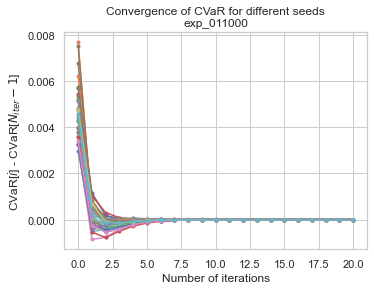

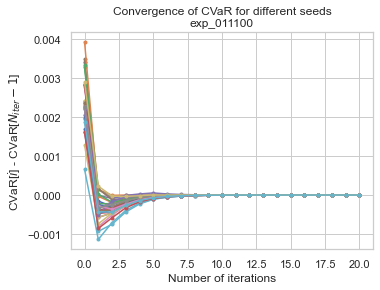

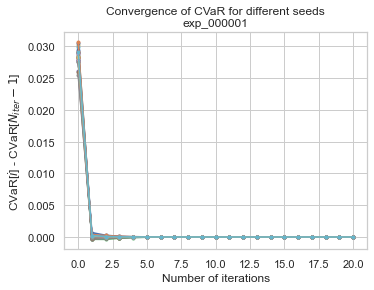

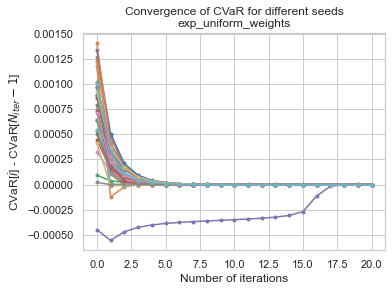

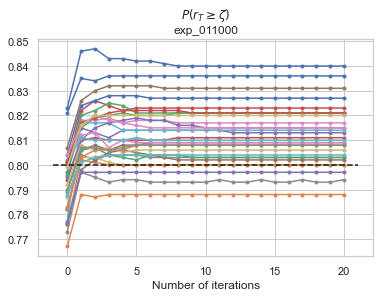

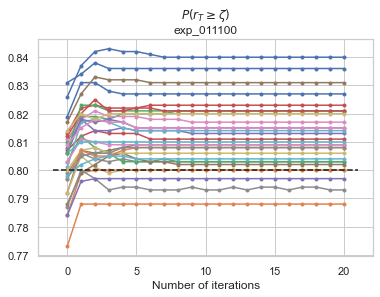

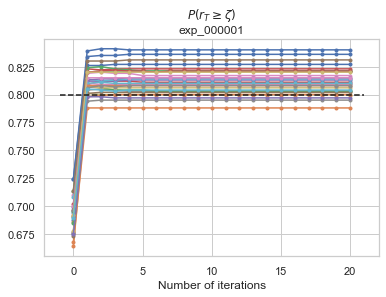

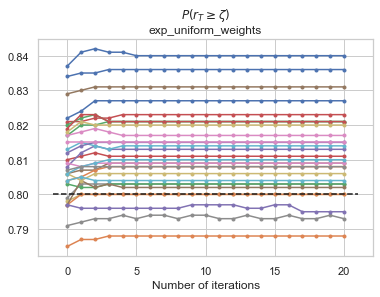

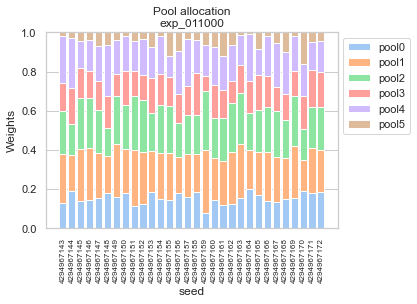

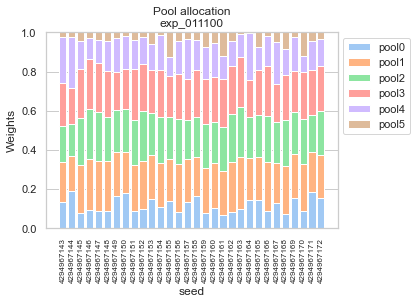

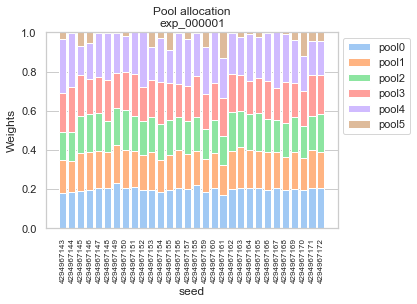

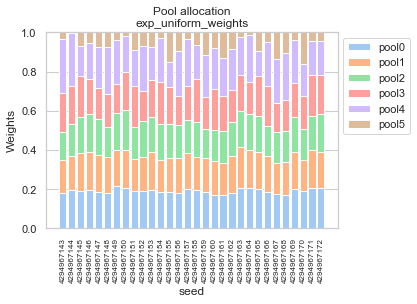

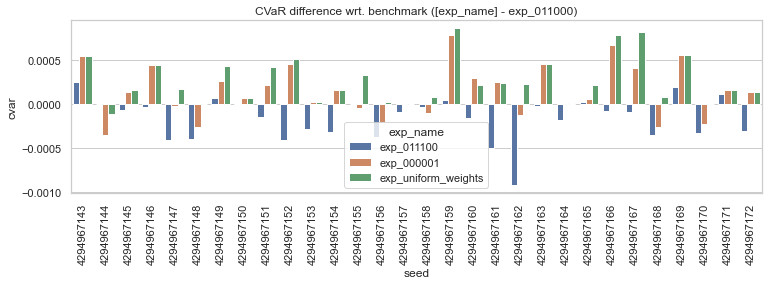

In [33]:
metrics_all = dict()
results_all = dict()
best_weights_all = dict()

for i, exp_name in enumerate(experiments):

    BASE_DIR = f"_output/{exp_name}"

    run_dirs = sorted(os.listdir(BASE_DIR), key=lambda x: x[-10:])
    
    results = dict()

    for run_dir in run_dirs[:N_total]:
        try:
            with open(os.path.join(BASE_DIR, run_dir, "params.json")) as f:
                params = json.load(f)
                seed = params['seed']
            weights = np.load(os.path.join(BASE_DIR, run_dir, "numpy/weights.npy"))
            metrics = np.load(os.path.join(BASE_DIR, run_dir, "numpy/metrics.npy"))
            results[seed] = {'weights': weights, 'metrics': metrics}
        except Exception as e:
            print(e)

    # find best weights and metrics
    weights = np.array([v['weights'][np.argmin(v['metrics'][:, 1])] for k, v in sorted(results.items())])
    metrics_best = np.array([v['metrics'][np.argmin(v['metrics'][:, 1])] for k, v in sorted(results.items())])
    
    ecdf_values = np.zeros((0,))
    
    metrics_all[exp_name] = np.vstack([metrics_best[:, 1:].T]).T
    results_all[exp_name] = results
    best_weights_all[exp_name] = weights
    
    os.makedirs(f"_plots/{exp_name}", exist_ok=True)

# convergence plot

for i, (exp_name, results) in enumerate(results_all.items()):
    
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.subplots_adjust(left=0.2)

    for k, v in results.items():
        ax.plot(v['metrics'][:, 1] - v['metrics'][-1, 1], marker='o', markersize=3)

    ax.set_title(f"Convergence of CVaR for different seeds\n{exp_name}")
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('CVaR[$i$] - CVaR[$N_{iter} - 1$]')
    
    fig.savefig(f'_plots/{exp_name}/convergence.pdf')

# constraint plot
    
for i, exp_name in enumerate(experiments):
    
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(np.array([v['metrics'][:, 2] for k, v in results_all[exp_name].items()]).T, marker='o', markersize=3)
    xmin, xmax = ax.get_xlim()
    ax.hlines(0.8, xmin, xmax, colors='k', linestyles='--')
    ax.set_title(f"$P(r_T \geq \zeta)$\n{exp_name}")
    ax.set_xlabel('Number of iterations')

    fig.savefig(f'_plots/{exp_name}/constraint.pdf')
    
# pool allocation plot
    
for i, (exp_name, weights) in enumerate(zip(experiments, best_weights_all.values())):
    
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.subplots_adjust(right=0.8, bottom=0.2)

    # Colors for each component
    colors = sns.color_palette("pastel")
    
    # Plot the stacked bar chart
    bottom = np.zeros(N_total)

    for j, component in enumerate(weights.T):
        ax.bar(seeds, component, bottom=bottom, label=f'pool{j}', color=colors[j])
        bottom += component

    # Add labels and legend
    ax.set_xlabel('seed')
    ax.set_ylabel('Weights')
    ax.set_ylim((0, 1))
    ax.set_title(f'Pool allocation\n{exp_name}')

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False, useOffset=False))
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticks(seeds, seeds, fontsize=8)

    fig.savefig(f'_plots/{exp_name}/allocation.pdf')
    
fig, ax = plt.subplots(figsize=(12, 4))
plt.subplots_adjust(top=0.8, bottom=0.2, left=0.1, right=0.9)

df = pd.concat([pd.DataFrame({'seed': seeds, 'cvar': metrics_all[exp_name][:N_total, 0] - metrics_all[exp_bench_name][:N_total, 0], 'exp_name': [exp_name] * N_total}) for i, exp_name in enumerate(experiments) if exp_name != exp_bench_name])
sns.barplot(x='seed', y='cvar', hue='exp_name', data=df, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_title(f'CVaR difference wrt. benchmark ([exp_name] - {exp_bench_name})')

fig.savefig('_plots/cvar_comparison.pdf')